In [4]:
import pandas as pd
import torch
import numpy as np

In [5]:
# Loss function: MSE
def loss_fn(target: torch.Tensor, network_output: torch.Tensor) -> torch.Tensor:
    return torch.mean(torch.square(target - network_output))

In [6]:
import sys
sys.path.append('..')

from utilities import linear_net

In [7]:
training_path = '../training_data/'
verification_path = '../verification_data/'
results_path = '../results/'
interpolating_for = 'exp_inv'

# Interpolating experiment

1. Plot target function and $\mathcal{NN}$ once training has concluded.
2. Represent the training process to visualize convergence.

In [8]:
verification_data = pd.read_csv(f"{verification_path}/verification_{interpolating_for}_linspace_{1000}.csv")
xx = torch.tensor(verification_data['x'], dtype = torch.float32)[:, None]

In [9]:
n_inputs = [3, 5, 10, 15]
dimensions = [2, 3, 4, 5, 10, 15, 20]
learning_rates = [-2, -3]

In [22]:
loss_log = []
for dim in dimensions:
    print(f'dim: {dim}')
    for lr_exp in learning_rates:
        print(f'lr {lr_exp}')
        for N in n_inputs:
            print(f'N {N}')
            # Load data
            input_data = pd.read_csv(f"{training_path}/input_{interpolating_for}_linspace_{N}.csv")
            x = torch.tensor(input_data['x'], dtype = torch.float32, requires_grad=False)[:, None]
            target = torch.tensor(input_data['y'], dtype = torch.float32, requires_grad=False)[:, None]

            for use_sigmoid in [True]:#[True, False]:
                # Get net
                NN = linear_net.Net(dim, torch.nn.Sigmoid()) if use_sigmoid \
                    else linear_net.Net(dim, torch.nn.ReLU(0.2))

                # Get optimizer
                optimizer = torch.optim.Adam(NN.parameters(), lr=10**lr_exp)

                # Training phase
                it_counter = 0
                while True:
                    optimizer.zero_grad()
                    loss = loss_fn(target, NN(x))
                    loss_log += [loss.item()]
                    if loss < 1e-7 or it_counter > 20000:
                        network_output = np.reshape(NN(xx).detach().numpy(), newshape=-1)
                        net_type = 'sigmoid' if use_sigmoid else 'relu'
                        pd.DataFrame(data = { 'x': verification_data['x'], 
                                            'y_target': verification_data['y'], 
                                            'y_nn': network_output})\
                                    .to_csv(f'{results_path}/training_performance_{interpolating_for}_input{N}_{net_type}_lr{lr_exp}_dim{dim}.csv',
                                            index=False)
                        pd.DataFrame(data = { 'loss': loss_log })\
                                    .to_csv(f'{results_path}/loss_{interpolating_for}_input{N}_{net_type}_lr{lr_exp}_dim{dim}.csv', index = False)
                        break
                    else:
                        loss.backward()
                        optimizer.step()
                        it_counter = it_counter + 1

dim: 2
lr -2
N 3
N 5
N 10
N 15
lr -3
N 3
N 5
N 10
N 15
dim: 3
lr -2
N 3
N 5
N 10
N 15
lr -3
N 3
N 5
N 10
N 15
dim: 4
lr -2
N 3
N 5
N 10
N 15
lr -3
N 3
N 5
N 10
N 15
dim: 5
lr -2
N 3
N 5
N 10
N 15
lr -3
N 3
N 5
N 10
N 15
dim: 10
lr -2
N 3
N 5
N 10
N 15
lr -3
N 3
N 5
N 10
N 15
dim: 15
lr -2
N 3
N 5
N 10
N 15
lr -3
N 3
N 5
N 10
N 15
dim: 20
lr -2
N 3
N 5
N 10
N 15
lr -3
N 3
N 5
N 10
N 15


Evaluate accuracy of the algorithm according to dimensionality, learning rate and number of inputs:

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create empty table
shape = (len(learning_rates), len(n_inputs), len(dimensions))
results = np.zeros(shape)

for l_index in range(len(learning_rates)):
    for n_index in range(len(n_inputs)):
        for d_index in range(len(dimensions)):
            n = n_inputs[n_index]
            d = dimensions[d_index]
            l = learning_rates[l_index]

            # Read csv file
            file_name = f"{results_path}training_performance_{interpolating_for}_input{n}_sigmoid_lr{l}_dim{d}.csv"
            df = pd.read_csv(file_name)

            # Do the computations we need
            subtraction = df['y_nn'] - df['y_target']
            size = len(subtraction)
            results[l_index, n_index, d_index] = ((subtraction ** 2).sum() / size) ** 0.5

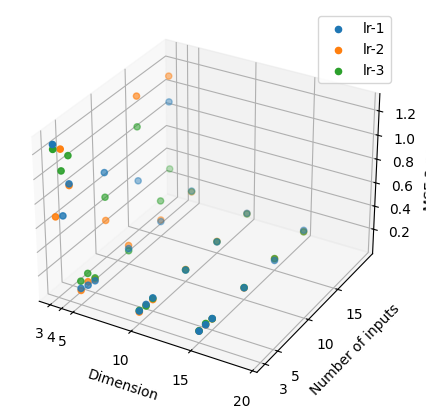

In [9]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(5,9))
ax = fig.add_subplot(111, projection='3d')

# Flatten the matrix into 1D arrays for x, y, and z
x = np.repeat(n_inputs, len(dimensions))
y = np.tile(dimensions, len(n_inputs))

# Create the scatter plot
for i in range(3):
    ax.scatter(x, y, results[i].flatten(), label=f'lr-{i+1}')

ax.set_xticks(dimensions)
ax.set_xlabel('Dimension')
ax.set_yticks(n_inputs)
ax.set_yticklabels(n_inputs)
ax.set_ylabel('Number of inputs')
ax.set_zlabel('MSE 2-norm')

ax.legend()

plt.show()

Plot accuracy and error:

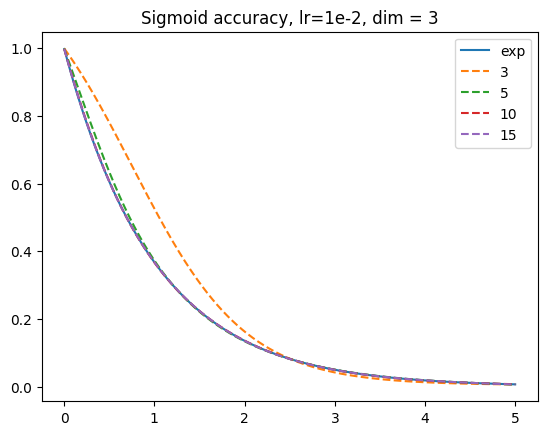

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(verification_data['x'], verification_data['y'], label = 'exp')
file_path = f'training_performance_{interpolating_for}_input'
for N in n_inputs:
    df = pd.read_csv(f'{results_path}{file_path}{N}_sigmoid_lr-2_dim3.csv')
    plt.plot(df['x'], df['y_nn'], label = N, linestyle='--')
plt.legend()
plt.title('Sigmoid accuracy, lr=1e-2, dim = 3')
plt.show()

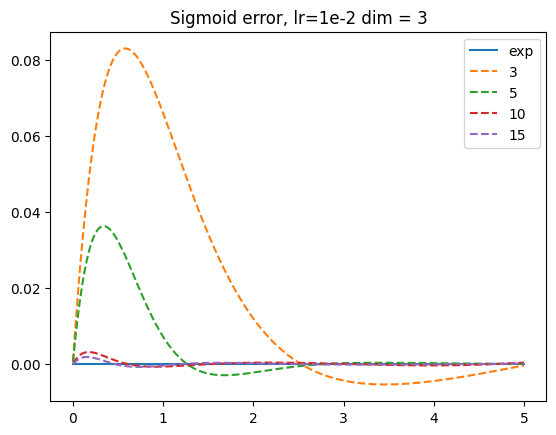

In [28]:
import matplotlib.pyplot as plt

plt.plot(verification_data['x'], 0 * verification_data['y'], label = 'exp')
file_path = f'training_performance_{interpolating_for}_input'
for N in n_inputs:
    df = pd.read_csv(f'{results_path}{file_path}{N}_sigmoid_lr-2_dim.csv')
    plt.plot(df['x'], (df['y_nn'] - df['y_target']), label = N, linestyle='--')
plt.legend()
plt.title('Sigmoid error, lr=1e-2 dim = 3')
plt.show()

# Show results

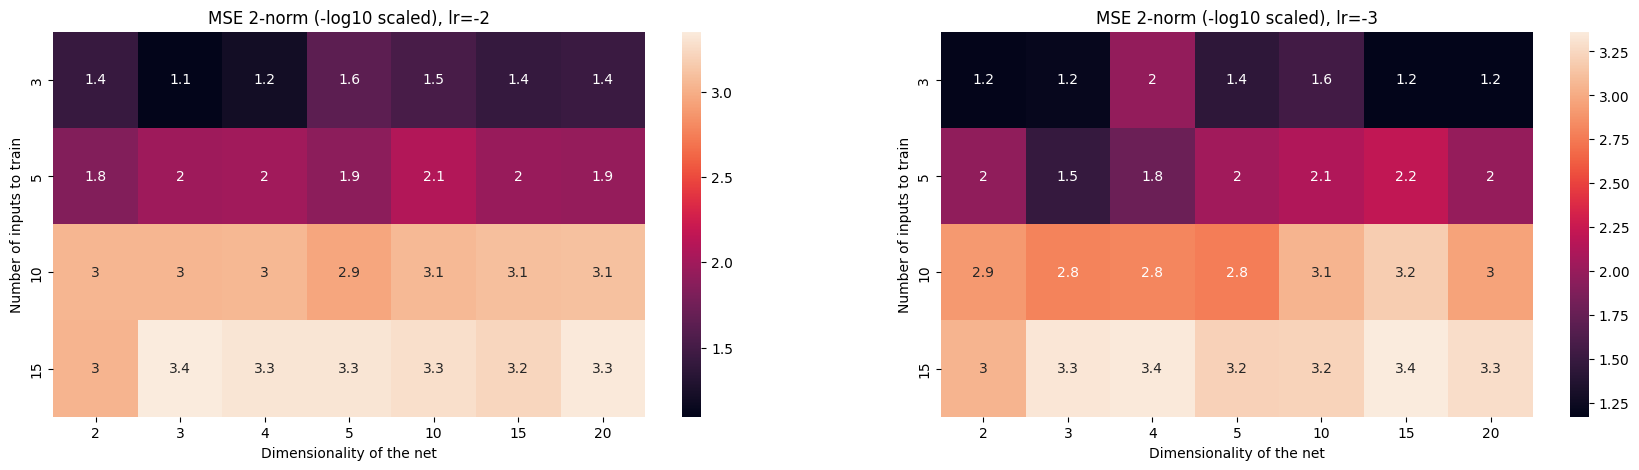

In [29]:
import seaborn
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (21, 5))
for ax_index in range(len(axes)):
    axes[ax_index].set_title(f'MSE 2-norm (-log10 scaled), lr={-(ax_index+2)}')

# x axis: dimension
# y axis: number of inputs

for idx in range(len(learning_rates)):
    input_data_sigmoid = -np.log10(results[idx]).reshape(len(n_inputs), len(dimensions))
    s = seaborn.heatmap(data = input_data_sigmoid, annot = input_data_sigmoid, 
                ax = axes[idx], xticklabels = dimensions, yticklabels = n_inputs)
    s.set(ylabel='Number of inputs to train', xlabel='Dimensionality of the net')